In [2]:
import pandas as pd
import numpy as np

PART-1

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = [0, 1, 2]

train_i = [i for i, (_, label) in enumerate(train_data) if label in classes]
test_i = [i for i, (_, label) in enumerate(test_data) if label in classes]

train_data = Subset(train_data, train_i)
test_data = Subset(test_data, test_i)


100%|██████████| 170M/170M [01:08<00:00, 2.50MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

labels = [train_data[i][1] for i in range(len(train_data))]

train_indices, val_indices = train_test_split(
    np.arange(len(labels)), test_size=0.2, stratify=labels, random_state=42
)

train_subset = Subset(train_data, train_indices)
val_subset = Subset(train_data, val_indices)


In [5]:
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label


PART-2

In [6]:
train_dataset = CustomCIFAR10Dataset(train_subset)
val_dataset = CustomCIFAR10Dataset(val_subset)
test_dataset = CustomCIFAR10Dataset(test_data)


In [7]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
from collections import Counter

def class_distribution(loader):
    counts = Counter()
    for _, labels in loader:
        counts.update(labels.tolist())
    return counts

print("Train class distribution:", class_distribution(train_loader))
print("Val class distribution:", class_distribution(val_loader))
print("Test class distribution:", class_distribution(test_loader))


Train class distribution: Counter({2: 4000, 1: 4000, 0: 4000})
Val class distribution: Counter({1: 1000, 0: 1000, 2: 1000})
Test class distribution: Counter({0: 1000, 1: 1000, 2: 1000})


In [10]:
from collections import defaultdict
def collect_images(loader, num_images=5):
    class_images = defaultdict(list)
    for images, labels in loader:
        for image, label in zip(images, labels):
            if len(class_images[label.item()]) < num_images:
                class_images[label.item()].append(image)
            if all(len(class_images[c]) == num_images for c in class_images.keys()):
                return class_images
    return class_images

# Collect images for each class in train and validation datasets
train_class_images = collect_images(train_loader)
val_class_images = collect_images(val_loader)

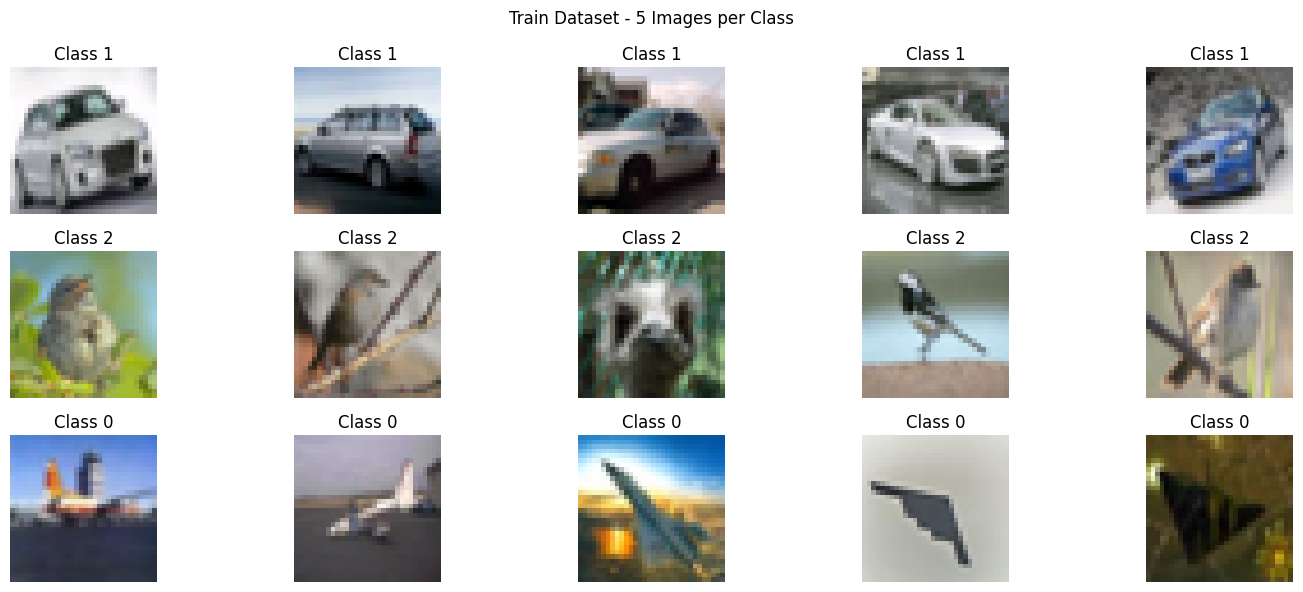

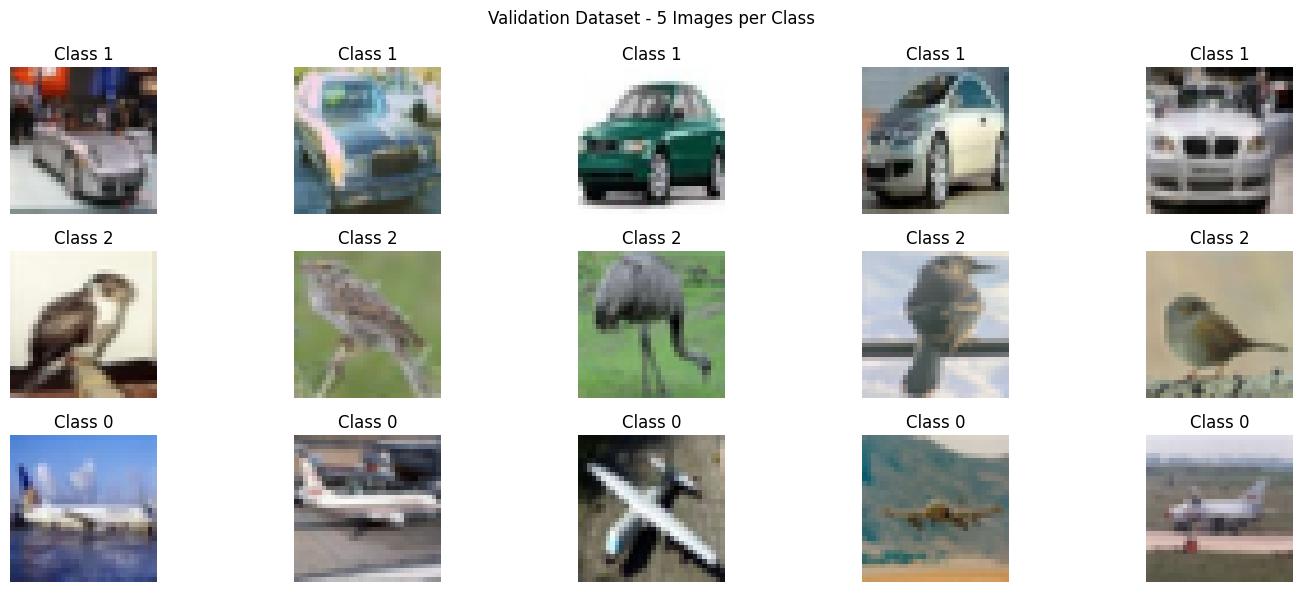

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 5, figsize=(15, 6))


# Visualize 5 images for each class from train dataset
for class_id, images in train_class_images.items():
    for i in range(5):
        ax = axes[class_id - 1, i]  # Access the correct row (class) and column (image index)
        ax.imshow(images[i].permute(1, 2, 0) / 2 + 0.5)  # Unnormalize image
        ax.axis('off')  # Remove axes
        ax.set_title(f'Class {class_id}')
plt.suptitle("Train Dataset - 5 Images per Class")
plt.tight_layout()
plt.show()

# Visualize 5 images for each class from validation dataset
fig, axes = plt.subplots(3, 5, figsize=(15, 6))

for class_id, images in val_class_images.items():
    for i in range(5):
        ax = axes[class_id - 1, i]  # Access the correct row (class) and column (image index)
        ax.imshow(images[i].permute(1, 2, 0) / 2 + 0.5)  # Unnormalize image
        ax.axis('off')  # Remove axes
        ax.set_title(f'Class {class_id}')
plt.suptitle("Validation Dataset - 5 Images per Class")
plt.tight_layout()
plt.show()


PART-3

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN architecture
class CustomCNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNNModel, self).__init__()
        
        # Convolutional and pooling layers
        self.conv_layer1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        self.pool_layer1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.pool_layer2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc_layer1 = nn.Linear(512, 16)  # Adjusted size for flattened feature map
        self.fc_layer2 = nn.Linear(16, num_classes)

    def forward(self, input_tensor):
        x = self.pool_layer1(F.relu(self.conv_layer1(input_tensor)))
        x = self.pool_layer2(F.relu(self.conv_layer2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_layer1(x))
        x = self.fc_layer2(x)
        
        return x


PART-4

In [14]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNNModel(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
        _, preds = torch.max(outputs, 1)
        correct = correct + (preds == labels).sum().item()
        total = total + labels.size(0)
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)
    
    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            li = loss.item()
            val_loss = val_loss + li
            _, preds = torch.max(outputs, 1)
            correct = correct + (preds == labels).sum().item()
            ls = labels.size(0)
            total = total + ls
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    p = epoch+1
    q = num_epochs
    
    print(f"Epoch {p}/{q}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")




Epoch 1/15, Train Loss: 0.7922, Train Acc: 0.6594, Val Loss: 0.6417, Val Acc: 0.7347
Epoch 2/15, Train Loss: 0.5654, Train Acc: 0.7744, Val Loss: 0.5415, Val Acc: 0.7803
Epoch 3/15, Train Loss: 0.5160, Train Acc: 0.7922, Val Loss: 0.5059, Val Acc: 0.7970
Epoch 4/15, Train Loss: 0.4599, Train Acc: 0.8180, Val Loss: 0.4905, Val Acc: 0.8083
Epoch 5/15, Train Loss: 0.4298, Train Acc: 0.8324, Val Loss: 0.4535, Val Acc: 0.8213
Epoch 6/15, Train Loss: 0.4092, Train Acc: 0.8404, Val Loss: 0.4219, Val Acc: 0.8313
Epoch 7/15, Train Loss: 0.3911, Train Acc: 0.8478, Val Loss: 0.4044, Val Acc: 0.8423
Epoch 8/15, Train Loss: 0.3678, Train Acc: 0.8553, Val Loss: 0.4035, Val Acc: 0.8413
Epoch 9/15, Train Loss: 0.3579, Train Acc: 0.8614, Val Loss: 0.3879, Val Acc: 0.8477
Epoch 10/15, Train Loss: 0.3534, Train Acc: 0.8612, Val Loss: 0.3847, Val Acc: 0.8533
Epoch 11/15, Train Loss: 0.3336, Train Acc: 0.8698, Val Loss: 0.3795, Val Acc: 0.8483
Epoch 12/15, Train Loss: 0.3189, Train Acc: 0.8763, Val Loss: 0

In [15]:
# Save the model
torch.save(model.state_dict(), "cnn_model.pth")

PART-5

Test Accuracy: 0.8713333333333333, Test F1-Score: 0.8711914071177965


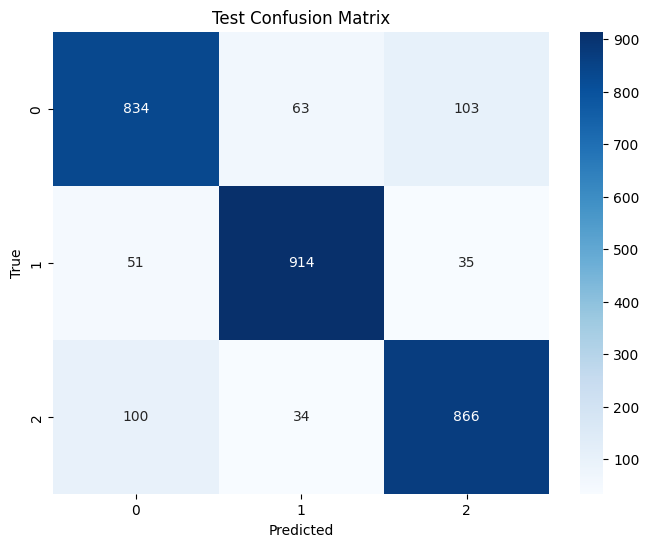

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on test set
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1_score = f1_score(test_labels, test_preds, average="weighted")
print(f"Test Accuracy: {test_accuracy}, Test F1-Score: {test_f1_score}")

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.show()


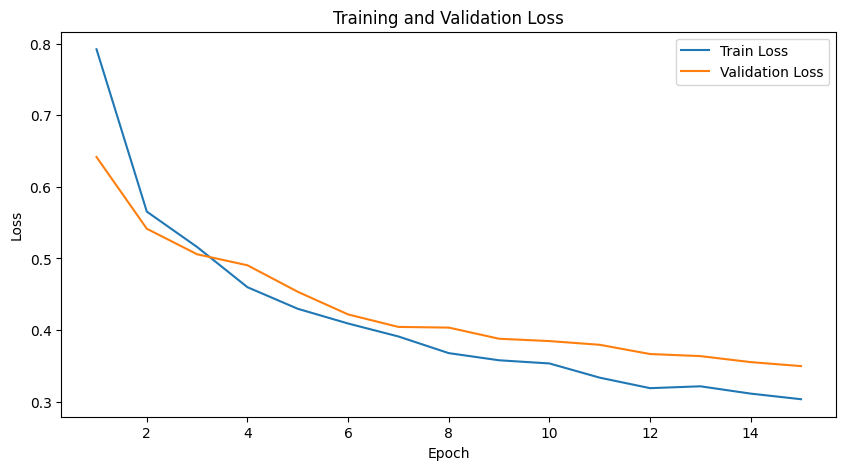

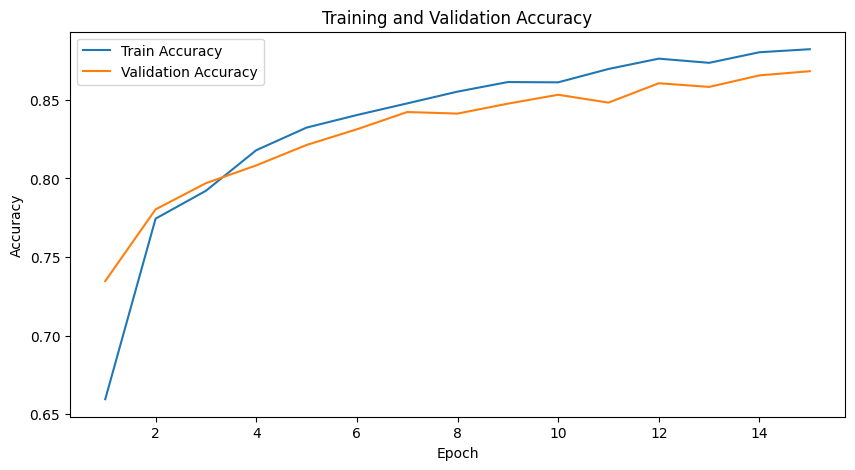

In [18]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


PART-6

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class MLPModel(nn.Module):
    def __init__(self, input_size=3 * 32 * 32, num_classes=3):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Flatten input
        x = x.view(x.size(0), -1)
        # Fully connected layers with activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Classification head
        return x


In [20]:
mlp_model = MLPModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
num_epochs = 15


In [22]:
# Initialize metrics storage
train_losses1, val_losses1 = [], []
train_accuracies1, val_accuracies1 = [], []

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    mlp_model.train()
    train_loss, train_correct = 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        outputs = mlp_model(images)
        
        # Adjust labels (if needed for 1, 2, 3 classes)
        # adjusted_labels = labels - 1
        
        # Compute loss and backpropagate
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct = train_correct + (predicted == labels).sum().item()
    
    # Calculate train metrics
    a = train_loader.dataset
    b = train_loader
    train_acc = train_correct / len(a)
    r = train_loss / len(b)
    train_losses1.append(r)
    train_accuracies1.append(train_acc)
    
    # Validation loop
    mlp_model.eval()
    val_loss, val_correct = 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mlp_model(images)
            
            # adjusted_labels = labels - 1
            loss = criterion(outputs, labels)
            
            val_loss = val_loss + loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct = val_correct + (predicted == labels).sum().item()
    
    # Calculate validation metrics
    x = val_loader.dataset
    y = val_loader
    vali_accuracy = val_correct / len(x)
    val_losses1.append(val_loss / len(y))
    val_accuracies1.append(vali_accuracy)
    
    # Logging for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_losses1[-1]:.4f}, Train Acc: {train_accuracies1[-1]:.4f} - "
          f"Val Loss: {val_losses1[-1]:.4f}, Val Acc: {val_accuracies1[-1]:.4f}")

# # Save the model after training
# torch.save(mlp_model.state_dict(), "mlp_model.pth")


Epoch [1/15] - Train Loss: 0.5177, Train Acc: 0.7984 - Val Loss: 0.5829, Val Acc: 0.7737
Epoch [2/15] - Train Loss: 0.4750, Train Acc: 0.8157 - Val Loss: 0.6076, Val Acc: 0.7687
Epoch [3/15] - Train Loss: 0.4482, Train Acc: 0.8274 - Val Loss: 0.5795, Val Acc: 0.7820
Epoch [4/15] - Train Loss: 0.4117, Train Acc: 0.8445 - Val Loss: 0.5843, Val Acc: 0.7750
Epoch [5/15] - Train Loss: 0.3795, Train Acc: 0.8547 - Val Loss: 0.5829, Val Acc: 0.7753
Epoch [6/15] - Train Loss: 0.3566, Train Acc: 0.8653 - Val Loss: 0.5877, Val Acc: 0.7877
Epoch [7/15] - Train Loss: 0.3270, Train Acc: 0.8807 - Val Loss: 0.5939, Val Acc: 0.7790
Epoch [8/15] - Train Loss: 0.3123, Train Acc: 0.8842 - Val Loss: 0.6131, Val Acc: 0.7843
Epoch [9/15] - Train Loss: 0.2923, Train Acc: 0.8931 - Val Loss: 0.6270, Val Acc: 0.7870
Epoch [10/15] - Train Loss: 0.2693, Train Acc: 0.9028 - Val Loss: 0.6601, Val Acc: 0.7640
Epoch [11/15] - Train Loss: 0.2565, Train Acc: 0.9073 - Val Loss: 0.6287, Val Acc: 0.7893
Epoch [12/15] - Tra

In [23]:
torch.save(mlp_model.state_dict(), "mlp_model.pth")

Part-7

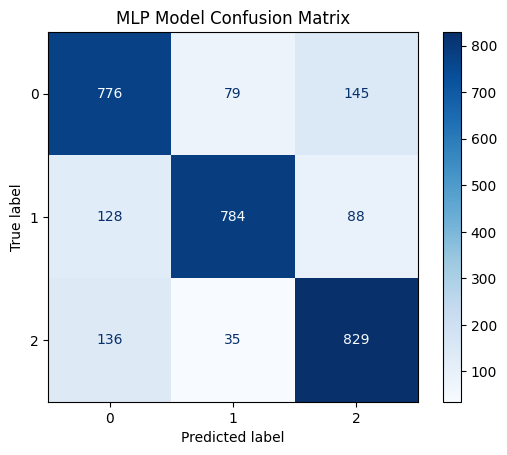

Test Accuracy (MLP): 0.7963
F1-Score (MLP): 0.7970


In [26]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set the model to evaluation mode
mlp_model.eval()

all_preds = []
all_labels = []
correct = 0

# Iterate through the test loader
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Adjust labels for evaluation if needed
        # adjusted_labels = labels - 1  # Adjust only if your labels are 1-based
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct = correct + (predicted == labels).sum().item()

# Calculate accuracy
test_accuracy = correct / len(test_loader.dataset)

# Calculate F1 score
test_f1 = f1_score(all_labels, all_preds, average="weighted")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2]).plot(cmap="Blues")
plt.title("MLP Model Confusion Matrix")
plt.show()

# Print metrics
print(f"Test Accuracy (MLP): {test_accuracy:.4f}")
print(f"F1-Score (MLP): {test_f1:.4f}")


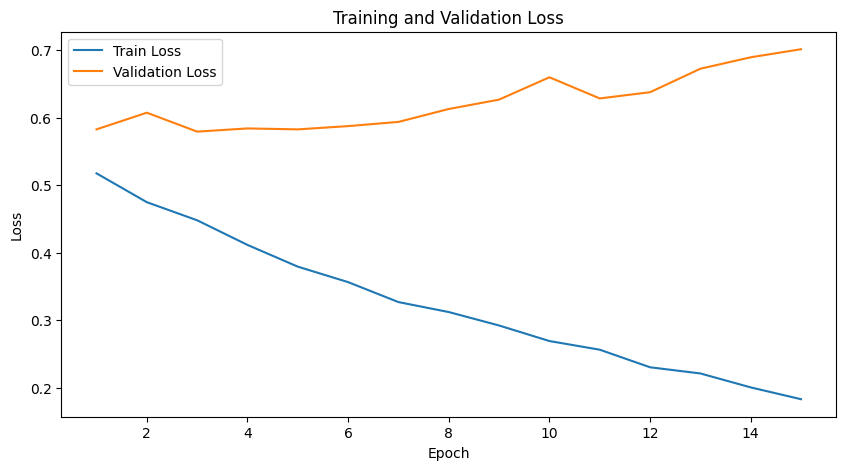

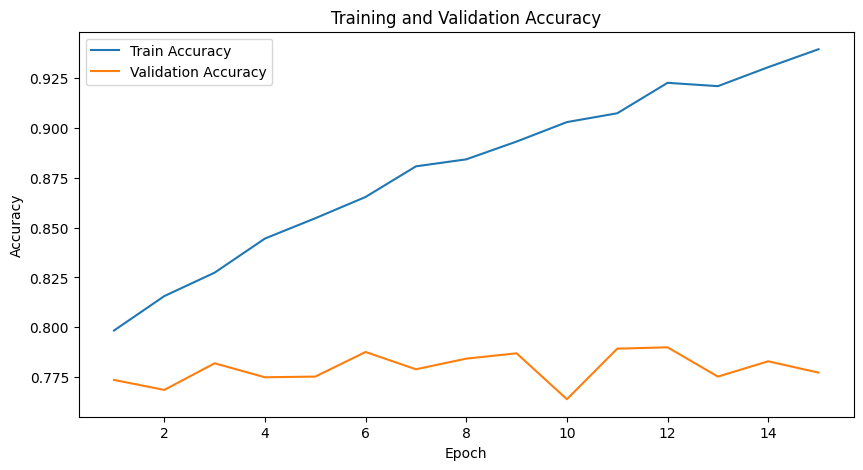

In [25]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses1, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses1, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies1, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies1, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()
